<a href="https://colab.research.google.com/github/subana-2k4/multimodel-emotion-detection/blob/main/multimodel_emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

!pip install whisper

In [4]:
!pip install -q openai-whisper moviepy librosa scikit-learn keras opencv-python

🔊 Upload an MP4 file for speech transcription and audio emotion detection:


Saving angry .m4a to angry .m4a
MoviePy - Writing audio in /content/temp_audio.wav


  warnings.warn("FP16 is not supported on CPU; using FP32 instead")



MoviePy - Done.
Transcription:  இடிஷ்டியும் காரிவேலையில் மாக்கடு, ஓசமரி செய்துக்கொண்டு இருக்கிறது,
Detected Emotion (Audio): angry
Detected Language: ta
🖼️ Upload a face image (JPG/PNG) for visual emotion detection:


Saving lau.jpg to lau.jpg
Detected Emotion (Face): Happy


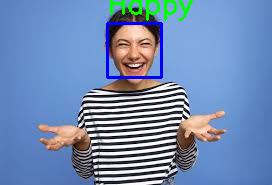

In [5]:
# ✅ Import Libraries
import whisper
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from moviepy.editor import AudioFileClip
from google.colab import files
import os
import cv2
from keras.models import load_model
from google.colab.patches import cv2_imshow

# ✅ Step 1: Load Whisper Model
asr_model = whisper.load_model("base")

# ✅ Step 2: Transcribe Speech
def transcribe_audio(audio_path):
    result = asr_model.transcribe(audio_path)
    print("Transcription:", result["text"])
    return result["text"], result["language"]

# ✅ Step 3: Extract Audio Features (MFCC + Pitch)
def extract_audio_features(audio_path):
    y, sr = librosa.load(audio_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    pitch, _ = librosa.core.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitch, axis=1)
    mfcc_features = np.mean(mfcc, axis=1)
    pitch_features = pitch_mean[:13]
    return np.concatenate([mfcc_features, pitch_features])

# ✅ Step 4: Train Dummy Emotion Classifier
def train_emotion_classifier():
    X = np.random.rand(100, 26)
    y = np.random.choice(['happy', 'sad', 'angry', 'neutral'], size=100)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    classifier = SVC(kernel='linear')
    classifier.fit(X, y_encoded)
    return classifier, le

# ✅ Step 5: Classify Audio Emotion
def classify_emotion(features, classifier, le):
    emotion_idx = classifier.predict([features])[0]
    emotion = le.inverse_transform([emotion_idx])[0]
    return emotion

# ✅ Step 6: Convert MP4 to WAV
def convert_mp4_to_wav(mp4_path, wav_path):
    audio_clip = AudioFileClip(mp4_path)
    audio_clip.write_audiofile(wav_path, codec='pcm_s16le')
    audio_clip.close()

# ✅ Step 7: Combined Audio Processing Function
def emotion_aware_speech_recognition(mp4_path):
    wav_path = "/content/temp_audio.wav"
    convert_mp4_to_wav(mp4_path, wav_path)
    transcription, language = transcribe_audio(wav_path)
    audio_features = extract_audio_features(wav_path)
    emotion = classify_emotion(audio_features, emotion_classifier, label_encoder)
    print(f"Detected Emotion (Audio): {emotion}")
    print(f"Detected Language: {language}")

# ✅ Step 8: Load Pretrained Face Emotion Model
!wget -q https://github.com/oarriaga/face_classification/raw/master/trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5 -O emotion_model.h5
face_model = load_model("emotion_model.h5", compile=False)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# ✅ Step 9: Process Uploaded Face Image
def detect_face_emotion(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        roi = gray[y:y+h, x:x+w]
        roi = cv2.resize(roi, (64, 64))
        roi = roi.astype("float32") / 255.0
        roi = np.expand_dims(roi, axis=-1)
        roi = np.expand_dims(roi, axis=0)
        preds = face_model.predict(roi, verbose=0)
        label = emotion_labels[np.argmax(preds)]
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        print(f"Detected Emotion (Face): {label}")

    cv2_imshow(img)

# ✅ Step 10: Train Audio Emotion Classifier
emotion_classifier, label_encoder = train_emotion_classifier()

# ✅ Step 11: Upload and Process Media
print("🔊 Upload an MP4 file for speech transcription and audio emotion detection:")
uploaded_audio = files.upload()
for filename in uploaded_audio.keys():
    emotion_aware_speech_recognition(f"/content/{filename}")

print("🖼️ Upload a face image (JPG/PNG) for visual emotion detection:")
uploaded_images = files.upload()
for filename in uploaded_images.keys():
    detect_face_emotion(filename)
